In [1]:
# import
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Example model, replace with your model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
from deap import base, creator, tools, algorithms
import random
from sklearn.model_selection import cross_val_score
import multiprocessing

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# 1. Load the dataset
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
# 2. Preprocess the data
# Handle any missing values (e.g., 'bmi' if there are NaNs)
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())  # Replace NaN in 'bmi' with mean

# Encode categorical variables (gender, ever_married, Residence_type)
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
data['ever_married'] = data['ever_married'].map({'No': 0, 'Yes': 1})
data['work_type'] = data['work_type'].map({'children': 0, 'Govt_job': 1, 'Never_worked':2,'Private':3, 'Self-employed':4,})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})
data['smoking_status'] = data['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})

# Use one-hot encoding for work_type and smoking_status
data = pd.get_dummies(data, columns=['work_type', 'smoking_status'], drop_first=True)

In [4]:
# 3. Define features and target; apply data augmentation
# Drop 'id' as it's just an identifier, and 'stroke' as it's the target variable
X = data.drop(['id', 'stroke'], axis=1)
y = data['stroke']

# Apply SMOTE before splitting the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print("\nOriginal dataset shape:", Counter(y))
print("Resampled dataset shape:", Counter(y_resampled))


Original dataset shape: Counter({0: 4861, 1: 249})
Resampled dataset shape: Counter({1: 4861, 0: 4861})


In [5]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [6]:
# 5. Standardize the data (if needed, depending on model choice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Delete existing classes if they exist
if 'FitnessMax' in creator.__dict__:
    del creator.FitnessMax
if 'Individual' in creator.__dict__:
    del creator.Individual

# Set up the genetic algorithm components with faster parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define genes with smaller ranges for faster convergence
toolbox.register("attr_n_estimators", random.randint, 50, 300)
toolbox.register("attr_max_depth", random.randint, 0, 30)
toolbox.register("attr_min_samples_split", random.randint, 2, 10)
toolbox.register("attr_min_samples_leaf", random.randint, 1, 5)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_estimators, toolbox.attr_max_depth,
                  toolbox.attr_min_samples_split, toolbox.attr_min_samples_leaf), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define evaluation function with optimized parameters
def evaluate(individual):
    model = RandomForestClassifier(
        n_estimators=individual[0],
        max_depth=None if individual[1] == 0 else individual[1],
        min_samples_split=individual[2],
        min_samples_leaf=individual[3],
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1', n_jobs=1)
    return (scores.mean(),)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[50,0,2,1], up=[300,30,10,5], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Create initial population with smaller size
population_size = 20  # Reduced from 30
n_generations = 4    # Reduced from 5
pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

# Run the evolution
print("Starting genetic algorithm optimization...")
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, 
                                 ngen=n_generations, stats=stats, 
                                 halloffame=hof, verbose=True)

# Get the best parameters
best_params = {
    'n_estimators': hof[0][0],
    'max_depth': None if hof[0][1] == 0 else hof[0][1],
    'min_samples_split': hof[0][2],
    'min_samples_leaf': hof[0][3]
}

print("\nBest parameters found:", best_params)

Starting genetic algorithm optimization...
gen	nevals	avg     	max     
0  	20    	0.913961	0.950357
1  	15    	0.945317	0.950357
2  	16    	0.947879	0.952204
3  	17    	0.950376	0.956437
4  	16    	0.949354	0.956437

Best parameters found: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [7]:
# 6. Train the model (using RandomForest as an example)
#model = RandomForestClassifier(random_state=42)
#model.fit(X_train, y_train)

# Train final model with best parameters
best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=28, n_estimators=56, n_jobs=-1,
                       random_state=42)

In [8]:
# 7. Make predictions
#y_pred = model.predict(X_test)

y_pred = best_model.predict(X_test)

In [9]:
# 8. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.961439588688946
Confusion Matrix:
 [[936  39]
 [ 36 934]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       975
           1       0.96      0.96      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



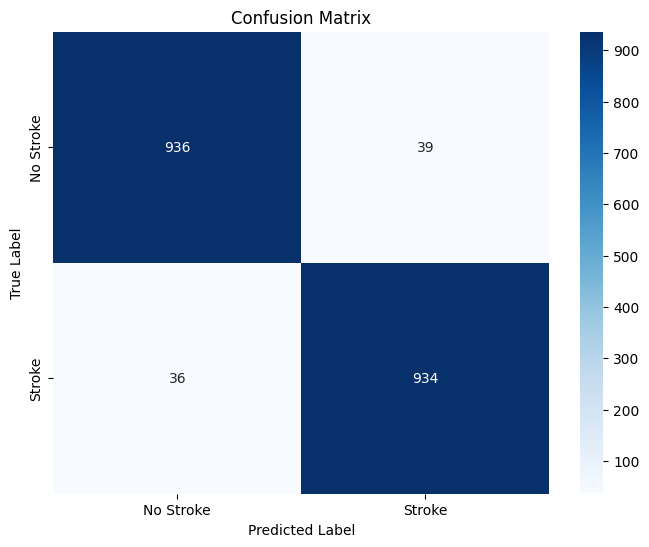


Model Performance Metrics:
Accuracy: 0.9614

Confusion Matrix Explanation:
True Negatives (top-left): 936
False Positives (top-right): 39
False Negatives (bottom-left): 36
True Positives (bottom-right): 934


In [10]:
# 9. Visualize the results
# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='Blues',  # Color scheme (you can change this)
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# You can also print the raw metrics for reference
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix Explanation:")
print("True Negatives (top-left):", conf_matrix[0][0])
print("False Positives (top-right):", conf_matrix[0][1])
print("False Negatives (bottom-left):", conf_matrix[1][0])
print("True Positives (bottom-right):", conf_matrix[1][1])

In [ ]:
# Plot evolution progress
gen = logbook.select("gen")
fit_avg = logbook.select("avg")
fit_max = logbook.select("max")

plt.figure(figsize=(10, 6))
plt.plot(gen, fit_avg, 'b-', label='Average Fitness')
plt.plot(gen, fit_max, 'r-', label='Maximum Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness (F1 Score)')
plt.title('Evolution of Fitness Over Generations')
plt.legend()
plt.grid(True)
plt.show()